# Benchmarking low complexity voting mechanisms 

## Dependencies

In [7]:
import random
import numpy as np
import math
import pandas as pd
import statistics
import seaborn as sns
import copy 
import itertools



In [8]:
from lwsocchoice.funcs import *
from lwsocchoice.votingRules import *
from lwsocchoice.models import * 

## Helper functions

 First we define some helper functions that will help with displaying the results

In [9]:
def myprint(string,x):
    print(string +": " + str(round(x,2)))

## Generate problem instance

We generate an instance with 1000 voters, and 8 alturnatives. We will use Borda scores as the desrised voting rule.

In [11]:
S_number = 8 #states
n_perms = len(list(itertools.permutations([i for i in range(S_number)]))) #divide alpha by this to create interesting distributions
N_voters = 1000 #voters
random.seed(1)

Next we generate a voting instance. We do this by drawing a preference orderings for each individual. 

In [12]:
true_orderings = zeroCorrelOrdering(N=N_voters,S=S_number,ALPHA_VAL=1/n_perms,asym_graph=True) #generate distribution of orderings, returns a dictionary
true_edge_weights = true_orderings["edge_weights"]
true_prob_values = true_orderings["prob_values"]

Using the generated preferences, we generate instances of voting objectives. 

In [13]:
V_inst = V(n_states=S_number,edge_weights=true_edge_weights,prob_values=true_prob_values) # generate V instance
votingrule = VotingRule(name="sym_borda",scoreFn=symBordaScoreFn) #pick voting rule
M_inst = M(n_states=S_number,n_voters=N_voters,V_INST=V_inst) # generate M instance

To demonstate functionality, we using the `updateGraphFixed' voting mechanism. This mechanism is resembles what is occurs most commonly in practice. A subset of states are chosen, and each voters determins thier preference ordering over these two states. We consider a subset of size 2.

In [14]:
# run benchmark
M_inst.updateGraphFixed(states_polled=2) #approximate graph
M_inst.applyVotingRule(votingrule)

print(M_inst)
print(M_inst.socialLossStats())

states 8 ; voter count 1000 ; MV distance 0.348000
{'voting_rule': 'sym_borda', 'ex ante social loss': None, 'polling scheme': 'updateGraphFixed', 'true_winner': 2, 'previous est_winner': 2, 'previous exPostLoss': 0.0}


We then try the 'updateGraphRS' voting mechanism. This mechanism asks each voter for their preference ordering over a random subset of states. Using the estimated pariwise election graph, the mechanism computes the expected Borda winner and selects this as the winner. We consider a subset of size 2.

In [15]:
# run approx
M_inst.updateGraphRS() #approximate graph
M_inst.applyVotingRule(votingrule) #apply rule 
print(M_inst)
print(M_inst.socialLossStats())

states 8 ; voter count 1000 ; MV distance 0.029000
{'voting_rule': 'sym_borda', 'ex ante social loss': None, 'polling scheme': 'updateGraphRS', 'true_winner': 2, 'previous est_winner': 2, 'previous exPostLoss': 0.0}


We then try the 'updateGraphRepBureau' voting mechanism. This mechanism selects a random `parliment' from the population. It then extracts the full preference ordering from the random parliment, and applies the voting rule to parliments preference ordering. We consider a comittee of 15 individuals. Note that in previous two cases, we require 1000 decisions in total as we require one decision from each voter. Presuming preferences are transitive, an individual can find their preference ordering in O(nlogn) time. A simple, but crude sorting algorithm can sort preferences 8^2 = 64 decisions. A random parliment could therefore contain at least 15 < 1000/64 members while using fewer total decisions than the previous mechanisms. 

In [16]:
# run random parliment
M_inst.updateGraphRepBureau(15) 
M_inst.applyVotingRule(votingrule)
print(M_inst)
print(M_inst.socialLossStats())

states 8 ; voter count 1000 ; MV distance 0.057000
{'voting_rule': 'sym_borda', 'ex ante social loss': None, 'polling scheme': 'updateGraphRepBureau', 'true_winner': 2, 'previous est_winner': 3, 'previous exPostLoss': 0.17114015261596505}


In this instance, both the 'updateGraphRS' and 'updateGraphRepBureau' mechanism correctly guess the socially optimal choice i.e. state 6. Fo the same set of preferences, we record the results for 100 instances of the random voting rules.

In [18]:
for i in ["updateGraphFixed","updateGraphRS","updateGraphRepBureau"]:
    M_inst.calcExAnteSocialLoss(votingRule=votingrule,sampling_scheme=i,iters=100,repBureau_size=15)
    myprint(i ,M_inst.exAnteSocialLoss)

updateGraphFixed: 1.16
updateGraphRS: 0.03
updateGraphRepBureau: 0.06


Across different realisations of the voting rules, 'updateGraphRS' appears to have the lowest expected distance to the socially optimal choice. However, this is specific to the particular preference ordering generated by the zeroCorrelOrdering function. 

## Benchmarking excersize

The previous excersize was for a particular choice of preference orderings, and a particular instance of the random  'updateGraphRS' and 'updateGraphRepBureau' mechanisms. To get a better idea of the performance of the schemes, albeit for the same number of states and voters, we repeat the excersize 100 times and record the results. 

In [19]:
S_number = 8 #states
n_perms = len(list(itertools.permutations([i for i in range(S_number)]))) #divide alpha by this to create interesting distributions
N_voters = 1000 #voters
votingrule = VotingRule(name="sym_borda",scoreFn=symBordaScoreFn) #pick voting rule
random.seed(2)
ITERS = 100

In [20]:
#initialise lists
updateGraphFixed_list = [-1]*ITERS
updateGraphRS_list = [-1]*ITERS
updateGraphRepBureau_list = [-1]*ITERS



for j in range(ITERS):
    # drawe preference distribution
    true_orderings = zeroCorrelOrdering(N=N_voters,S=S_number,ALPHA_VAL=1/n_perms,asym_graph=True) #generate distribution of orderings, returns a dictionary
    true_edge_weights = true_orderings["edge_weights"]
    true_prob_values = true_orderings["prob_values"]

    V_inst = V(n_states=S_number,edge_weights=true_edge_weights,prob_values=true_prob_values) # generate V instance
    M_inst = M(n_states=S_number,n_voters=N_voters,V_INST=V_inst) # generate M instance

    #store results 
    M_inst.calcExAnteSocialLoss(votingRule=votingrule,sampling_scheme='updateGraphFixed',iters=1,repBureau_size=15)
    updateGraphFixed_list[j] = M_inst.exAnteSocialLoss

    M_inst.calcExAnteSocialLoss(votingRule=votingrule,sampling_scheme='updateGraphRS',iters=1,repBureau_size=15)
    updateGraphRS_list[j] = M_inst.exAnteSocialLoss

    M_inst.calcExAnteSocialLoss(votingRule=votingrule,sampling_scheme='updateGraphRepBureau',iters=1,repBureau_size=15)
    updateGraphRepBureau_list[j] = M_inst.exAnteSocialLoss


print('mean updateGraphFixed: %f' % np.mean(updateGraphFixed_list))
print('mean updateGraphRS: %f' % np.mean(updateGraphRS_list))
print('mean updateGraphRepBureau: %f' % np.mean(updateGraphRepBureau_list))


We then plot the distributions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
i

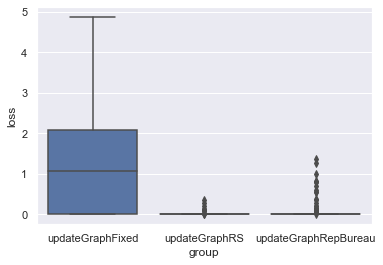

In [ ]:
sns.set(style='darkgrid')

df = pd.DataFrame({'group': ['updateGraphFixed']*ITERS + ['updateGraphRS']*ITERS + ['updateGraphRepBureau']*ITERS,
                   'loss': updateGraphFixed_list + updateGraphRS_list + updateGraphRepBureau_list})


sns.boxplot(x='group',y='loss',data=df)
plt.show()

'updateGraphRS' appears to have the tight distribution close to zero, suggsting it is the best scheme for our prior distribution over preference types.